# Quantum Variational Rewinding for Time Series Anomaly Detection

The following demonstration is based upon the *Quantum Variational Rewinding* algorithm, or, QVR, proposed by [Baker, Horowitz, Radha et. al (2022)](https://arxiv.org/abs/2210.16438) [[1]](#Baker2022).

<img src="./images/placeholder_image.jpeg" alt="drawing" width="400"/>
<!-- ![placeholder](./images/placeholder_image.jpeg) -->

QVR is a quantum machine learning algorithm for the well known task of time series anomaly detection. The method leverages the power of unitary time evolution/devolution operators to learn a model of *normal* behaviour for time series data. Given a new (unseen in training) time series, the normal model produces a value, which beyond a threshold, defines anomalous behaviour. In this tutorial, we'll be showing you how all of this works, combining elements from [Covalent](https://www.covalent.xyz/), [Pennylane](https://pennylane.ai/) and [PyTorch](https://pytorch.org/). 

In [13]:
import covalent as ct
import torch
import matplotlib.pyplot as plt
import pennylane as qml
from itertools import combinations
from collections.abc import Iterator

# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 1989
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)

## Background

To begin, let's quickly recount the data that QVR handles: time series. A general time series $\boldsymbol{y}$ can be described as an integer $p$-length sequence of observations of a process/system in chronological order

$$
\boldsymbol{y} := (\boldsymbol{y}_t: t \in T), \quad T := (t_l: 1 \leq l \leq p).
$$

In the simple and didactic case treated in this tutorial, we deal with the case where $\boldsymbol{y}$ is univariate (i.e, is a one-dimensional time series) so bold-face for $\boldsymbol{y}$ is dropped. Also, we take $y_t \in \mathbb{R}$ and $t_l \in \mathbb{R}_{>0}$

The goal of QVR and many other (classical) machine learning algorithms for time series anomaly detection is to determine a suitable *anomaly score* function $a_{X}$. When passed a general time series $y$, This function produces a real number: $a_X(y) \in \mathbb{R}$. $a_{X}$ is learned from a training set of time series instances known to exhibit normal behaviour $x \in X$ ($x$ is defined analogously to $y$ in the above) where the goal is to have $a_X(x) \rightarrow 0, \forall x \in X$. Then, for an unseen time series $y$, the series is said to be anomalous should $a_X(y) > \zeta$ and normal otherwise for threshold $\zeta \in \mathbb{R}$. We show a strategy for setting $\zeta$ later in this tutorial.

The first step for doing all of this *quantumly* is to generate a sequence $\mathcal{S} := (|x_{t} \rangle| t \in T)$ of $n$-qubit quantum states corresponding to a classical time series instance in the training set. Now, we suppose that each $|x_t \rangle$ is a quantum state evolved to a time $t$ as generated by an *unknown embedding Hamiltonian* $H_E$. That is, each element of $\mathcal{S}$ is defined by $|x_t \rangle = e^{-iH_E(x_t)}|0\rangle^{\otimes n} = U(x_t)|0\rangle^{\otimes n}$ for embedding unitary operator $U(x_t)$ implementing a quantum feature map (see the [Pennylane embedding templates](https://docs.pennylane.ai/en/stable/introduction/templates.html#embedding-templates) for efficient quantum circuits for doing so). Next, We operate on each $|x_t\rangle$ with a parameterized $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ operator to prepare the states

$$
|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle := e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}|x_t\rangle
$$

where we write $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ as an eigendecomposition

$$
V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha}) = e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}
$$

for $\boldsymbol{\alpha}$-parametrized unitary matrix of eigenvectors $W(\boldsymbol{\alpha})$ and $\boldsymbol{\gamma}$-parametrized diagonal unitary operator $D(\boldsymbol{\gamma}, t)$ where both can be implemented efficiently using parameterized quantum circuits. The above equality with $e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}$ is a consequence of Stone's theorem for strongly continuous one-parameter unitary groups [[2]](#Stone1932).

We now ask the question: *What condition is required for $|x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma} \rangle$ = $|0\rangle^{\otimes n}$ for all time?* This answer can be formalized in math as

$$
\forall t, |0\rangle^{\otimes n} \langle 0|^{\otimes n}e^{-iH(\boldsymbol{\alpha}, \boldsymbol{\gamma})t}e^{-iH_E(x_t)}|0\rangle^{\otimes n} = 1 \iff \forall t, H(\boldsymbol{\alpha}, \boldsymbol{\gamma})t = -H_E(x_t).
$$

In other words, for the above to be true, the parameterized unitary operator $V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma})$ should be able to reverse or *rewind* $|x_t\rangle$ to it's initial condition before the embedding unitary operator $U(x_t)$ was applied: $|0\rangle^{\otimes n}$.

We are nearly there! Because it is reasonable to expect that a single Hamiltonian will not be able to successfully rewind every $x \in X$ (in fact this is impossible to do so exactly each $x$ is unique), we consider the average effect of many Hamiltonians generated by drawing $\boldsymbol{\gamma}$ from a normal distribution $\mathcal{N}(\mu, \sigma)$

$$
F(\boldsymbol{\phi}, x_t) = \mathop{\mathbb{E}_{\boldsymbol{\gamma} \sim \mathcal{N}(\mu, \sigma)}}\left[|0\rangle^{\otimes n} \langle 0|^{\otimes n} |x_t, \boldsymbol{\alpha}, \boldsymbol{\gamma}\rangle  \right], \quad \boldsymbol{\phi} = [\boldsymbol{\alpha}, \mu, \sigma].
$$

The goal is for the above to be $\approx 1$ $\forall x \in X$ and $\forall t$. With this in mind, we can define the loss function to minimize as the mean square error (MSE) regularized by a penalty function $P_{\tau}(\sigma)$ with a single hyperparameter $\tau$.

$$
\mathcal{L(\boldsymbol{\phi})} = \frac{1}{2|X||T|}\sum_{x \in X} \sum_{t \in T}[1 - F(\boldsymbol{\phi}, x_t)]^2 + P_{\tau}(\sigma)
$$

Where we shall show the exact form of $P_{\tau}(\sigma)$ later. The general purpose of the penalty function, however, is to penalize large values of $\sigma$ (justification for this is given in the Supplement of [[1]](Baker2022)). After approximately finding $\boldsymbol{\phi}^{\star} = \text{argmin}_{\phi}[\mathcal{L}(\boldsymbol{\phi})]$ with a classical optimization routine, we finally arrive at a definition for our anomaly score function $a_X(y)$

$$
a_X(y) = \frac{1}{|T|}\sum_{t \in T}[1 - F(\boldsymbol{\phi}^{\star}, y_t)]^2.
$$

It may now be apparent that we have implemented a clustering algorithm! That is, our model $F$ was trained such that normal time series $x \in X$ produce $F(\boldsymbol{\phi}^{\star}, x_t)$ clustered about a center at $1$. Given a new time series $y$, should $F(\boldsymbol{\phi}^{\star}, y_t)$ venture far from the normal center at 1, we are observing anomalous behaviour!

Now with our algorithm defined, let's stich this all together: enter [Covalent](https://www.covalent.xyz/)


## Covalent: heterogeneous workflow orchestration 

Presently, many QML algorithms are *heterogeneous* in nature. That is, they require compute resources from different computation paradigms: classical and quantum computation. Covalent is a tool that can be used to manage their interaction by sending different tasks to different compute resources and stiching them together as a workflow. While you will be introduced to other concepts in Covalent throughout this tutorial, to begin we define two key components.

1. **Electrons**. Decorate regular Python functions with `@ct.electron` to desginate a *task*. These are the atoms of computation.

2. **Lattices**. Decorate a regular Python function with `@ct.lattice` to designate a *workflow*. These contain electrons and stich them together to do something useful.

![training](./images/covalent_platform.png)

## Generating univariate synthetic time series

In this tutorial, we shall deal with a simple and didactic example. Normal time series instances are chosen to be noisy low-amplitude noise signals about the origin: $x_t \sim \mathcal{N}(0, 0.1)$ and the series we deem to be anomalous are the same but with randomly inserted spikes with random duration and amplitude.

Let's make a `@ct.electron` to generate each of these synthetic time series sets. 

In [14]:
@ct.electron
def generate_normal_time_series_set(
    p: int,
    num_series: int,
    noise_amp: float,
    t_init: float,
    t_end: float,
    seed: int = GLOBAL_SEED
) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate a normal time series data set where each element
    is drawn from a normal distribution $x_t \sim N(0, noise_amp)$  
    Args:
        p(int): length of each time series instance
        num_series(int): the total number of time series in the set
        noise_amp(float): standard deviation of normal distribution data is
        drawn from
        t_init(float): time time each time series starts from
        t_end(float): the time each time series ends at
        seed(int): random seed for torch for reproducibility
    Returns:
        tuple(torch.Tensor, torch.Tensor): the time series set X and the time
        set T
    """
    torch.manual_seed(seed)
    X = torch.normal(0, noise_amp, (num_series, p))
    T = torch.linspace(t_init, t_end, p)
    return X, T

@ct.electron
def generate_anomalous_time_series_set(
    p: int,
    num_series: int,
    noise_amp: float,
    spike_amp: float, 
    max_duration: int, 
    t_init: float, 
    t_end: float, 
    seed: int = GLOBAL_SEED
) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate an anomalous time series data set where each element
    is drawn from a normal distribution $x_t \sim N(0, noise_amp)$ then 
    anomalous spikes of a random amplitude are inserted 
    Args:
        p(int): length of each time series instance
        num_series(int): the total number of time series in the set
        noise_amp(float): standard deviation of normal distribution data is
        drawn from
        spike_amp(float): standard deviation of normal distribution that
        anomalous spikes are drawn from
        max_duration(int): maximum number of subsequent time steps an anomalous
        spike can occur on
        t_init(float): time time each time series starts from
        t_end(float): the time each time series ends at
        seed(int): random seed for torch for reproducibility
    Returns:
        tuple(torch.Tensor, torch.Tensor): the time series set Y and the time
        set T
    """
    torch.manual_seed(seed)
    Y = torch.normal(0, noise_amp, (num_series, p))
    for y in Y:
        # 5-10 spikes allowed
        spike_num = torch.randint(low=5, high=10, size=())
        durations = torch.randint(low=1, high=max_duration, size=(spike_num,))
        spike_start_idxs = torch.randperm(p-max_duration)[:spike_num]
        for start_idx, duration in zip(spike_start_idxs, durations):
            y[start_idx:start_idx + duration] +=\
                 torch.normal(0.0, spike_amp,(duration,))
    T = torch.linspace(t_init, t_end, p)
    return Y, T

Like many machine learning algorithms, training is done in mini-batches. Examining the form of the loss function $\mathcal{L}(\boldsymbol{\phi})$, we can see that time series are atomized. In other words, each term in the MSE is for a given $x_t$ and not measured against the entire series $x$. This allows us to break down the training set $X$ into into time-series independant chunks. Here's an electron to do that:

In [15]:
@ct.electron
def make_atomized_training_set(
    X: torch.Tensor, 
    T: torch.Tensor 
) -> list[tuple[torch.Tensor, torch.Tensor]]:
    """Convert input time series data in a two-dimensional tensor format
    into atomized tuple chunks: (xt, t). 
    Args:
        X(torch.Tensor): time series training data set with size
        (num_series, p)
        T: set of time values with size (p,)
    Returns:
        list[tuple[torch.Tensor, torch.Tensor]]: an atomized version of the 
        input time series data set
    """
    X_flat = torch.flatten(X)
    T_flat = T.repeat(X.size()[0])
    atomized = [(xt, t) for xt, t in zip(X_flat, T_flat)]
    return atomized

We now wish to pass this to a cycled `torch.utils.data.DataLoader`. However, this object is not [*pickleable*](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.) which is a requirement of electrons in covalent. We therefore use the below helper class to create a pickleable version.

In [16]:
class DataGetter:
    """A pickleable mock-up of python iterator on a torch.utils.Dataloader

    Attributes:
        X(torch.Tensor): the data set you wish to iterate over
        batch_size(int): the size of each batch when next() is called on an
        instances of this class
        data(list): a list to hold all of the data in a non-iterator form
    """
    def __init__(
        self,
        X: torch.Tensor,
        batch_size: int,
        seed: int = GLOBAL_SEED
    ) -> None:
        """Calls the _init_data method on intialization of a DataGetter object

        Args:
            X(torch.Tensor): the data set you wish to iterate over
            batch_size(int): the size of each batch when next() is called on an
            instance of this class
        """
        torch.manual_seed(seed)
        self.X = X
        self.batch_size = batch_size
        self.data = []
        self._init_data(
            iter(
                torch.utils.data.DataLoader(self.X,
                                            batch_size=self.batch_size,
                                            shuffle=True)
            )
        )

    def _init_data(self, iterator: Iterator[tuple[torch.Tensor]]) -> None:
        """Load all of the iterator into a list

        Args:
            iterator(Iterator[tuple[torch.Tensor]]): a python iterator over
            a data set comprised of torch.Tensor objects
        Returns:
            None
        """
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self) -> tuple[torch.Tensor]:
        """Analagous behaviour to the native python next() but calling the 
        .pop() of the data attribute.
            Args:
                None
            Returns:
                tuple[torch.Tensor]: a batch from the original 
                torch.utils.Dataloader object
        """
        try:
            return self.data.pop()
        except(IndexError): # Caught when the data set runs out of elements
            self._init_data(
                iter(
                    torch.utils.data.DataLoader(self.X,
                                                batch_size=self.batch_size,
                                                shuffle=True)
                )
            )
        finally:
            return self.data.pop()

We call an instance of the above in an electron

In [17]:
@ct.electron
def get_training_cycler(
    Xtr: torch.Tensor,
    batch_size: int,
    seed: int = GLOBAL_SEED
) -> DataGetter:
    """Get an instance of the DataGetter class which behaves analagously to 
    next(iterator) but is pickleable

    Args:
        Xtr(torch.Tensor): the training dataset
        batch_size(int): the size of each batch when next() is called on an
        instances of this class
        seed(int): random seed for torch for reproducibility
    Returns:
        DataGetter: an instance of the DataGetter helper class
    """
    return DataGetter(Xtr, batch_size, seed)

Now we have the means to create synthetic data and cycle through a training set, we need to build our loss function  $\mathcal{L}(\boldsymbol{\phi})$ from electrons with the help of `Pennylane`.

## Building the loss function

Core to building the loss function is the quantum circuit implementing $V_t(\boldsymbol{\alpha}, \boldsymbol{\gamma}) := W^{\dagger}(\boldsymbol{\alpha})D(\boldsymbol{\gamma}, t)W(\boldsymbol{\alpha})$. While there are existing templates in `Pennylane` for implementing $W(\boldsymbol{\alpha})$, we use a custom circuit to implement $D(\boldsymbol{\gamma}, t)$. Following the approach taken in [[3]](#Welch2014) (also explained in [[1]](#Baker2022) the appendix of ref. [[4]](#Cîrstoiu2020)), we create the electron:

In [18]:
@ct.electron
def D(gamma: torch.Tensor, n: int, k: int = None) -> None:
    """Generates a quantum circuit according to a limited Walsh operator
    expansion. See <https://doi.org/10.1088/1367-2630/16/3/033040> for more
    details.

    Args:
        gamma(torch.Tensor): a vector of variational parameters
        n(int): the number of qubits for the quantum circuit
        k(int): the k-locality of the diagonal unitary
    Returns:
        None
    """
    if k is None:
        k = n
    cnt = 0
    # Note there NO explicit loop over all 2^n eigenvalues
    for i in range(1, k + 1):
        for comb in combinations(range(n), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)

Next, we define a circuit to measure the probabilties in the computational basis. In our simple example, we work only with one qubit and use the `default.qubit` local quantum circuit simulator.

In [7]:
n_qubits = 1

@ct.electron
@qml.qnode(
    qml.device('default.qubit', wires=n_qubits, shots=None),
    interface='torch',
    diff_method="backprop"
)
def get_probs(
    xt: torch.Tensor,
    t: float,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    k: int,
    U: callable,
    W: callable,
    D: callable,
    n_qubits: int
) -> torch.Tensor:
    """Measure the probabilities for measuring each bitstring after applying a
    circuit of the form $W^{dagger}DWU$ to the $|0\rangle^{\otimes n}$ state.

    Args:
       xt(torch.Tensor): a 1D tensor with a single value xt
       t(float): time
       alpha(torch.Tensor) 
    """
    U(xt, wires=range(n_qubits))
    W(alpha, wires=range(n_qubits))
    D(gamma * t, n_qubits, k)
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    return qml.probs(range(n_qubits))

To take the projector $|0\rangle^{\otimes n} \langle 0 |^{\otimes n}$, we consider only the probability of measuring $|0\rangle^{\otimes n}$, which is the $0^{th}$ element of the probabilities (bit strings are returned in lexographic order) 

In [8]:
@ct.electron
def get_callable_projector_func(k, U, W, D, n_qubits, probs_func):
    callable_proj =\
         lambda xt, t, alpha, gamma:\
             probs_func(xt, t, alpha, gamma, k, U, W, D, n_qubits)[0]
    return callable_proj

We now have the neccessary ingedients to build $F(\boldsymbol{\phi}, x_t)$

In [9]:
@ct.electron
def F(callable_proj, xt, t, alpha, mu, sigma, gamma_length, n_samples):
    # length of gamma should not exceed 2^n - 1
    gammas = sigma.abs()*torch.randn((n_samples, gamma_length)) + mu
    expectation = torch.empty(n_samples)
    for i, gamma in enumerate(gammas):
        expectation[i] = callable_proj(xt, t, alpha, gamma)
    return expectation.mean()

We now return to the matter of the penalty function $P_{\tau}$. While any sigmoidal-type function can be used, we choose

$$
P_{\tau}(\sigma) := \frac{1}{\pi} \arctan(2 \pi \tau |\sigma|) 
$$ 

In [10]:
@ct.electron
def callable_arctan_penalty(tau):
    prefac = 1/(torch.pi)
    callable = lambda sigma:\
         prefac*torch.arctan(2*torch.pi*tau*sigma.abs()).mean()
    return callable


where the prefactor is choen such that the final loss $\mathcal{L}(\boldsymbol{\phi})$ is defined in the range (0, 1), as defined in the below electron.

In [11]:
@ct.electron
def get_loss(callable_proj, batch, alpha, mu, sigma, gamma_length, n_samples,
             callable_penalty):
    X_batch, T_batch = batch
    loss = torch.empty(X_batch.size()[0])
    for i in range(X_batch.size()[0]):
        # unsqueeze required for tensor to be correct dimension for PL templates
        loss[i] =  (1 - F(callable_proj, X_batch[i].unsqueeze(0), T_batch[i].unsqueeze(0),
                    alpha, mu, sigma, gamma_length, n_samples)).square()
    return 0.5*loss.mean() + callable_penalty(sigma)

## Training the normal model

Now equipped with a loss function, we need to minimize it with a classical optimization routine. To start this optimization, however, we need some initial parameters. We can generate them with the below electron

In [13]:
@ct.electron
def get_initial_parameters(W, W_layers, n_qubits, seed=GLOBAL_SEED):
    torch.manual_seed(seed)
    init_alpha =\
         torch.rand(W.shape(W_layers, n_qubits))
    init_mu = torch.rand(1)
    # Best to start sigma small and expand if needed
    init_sigma = torch.rand(1)
    init_params = \
        {'alpha': (2*torch.pi*init_alpha).clone().detach().requires_grad_(True),
         'mu': (2*torch.pi*init_mu).clone().detach().requires_grad_(True),
         'sigma': (0.1*init_sigma + 0.05).clone().detach().requires_grad_(True)}
    return init_params

Using the `Pytorch` interface to `Pennylane`, we define our final electron before running the training workflow.

In [14]:
@ct.electron 
def train_model_gradients(lr, init_params, pytorch_optimizer, cycler,
                          n_samples, callable_penalty, batch_iterations,
                          callable_proj, gamma_length, seed=GLOBAL_SEED,
                          print_intermediate=False):
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params['alpha']
    mu = init_params['mu']
    sigma = init_params['sigma']

    def closure():
        opt.zero_grad()
        loss = get_loss(callable_proj, next(cycler), alpha, mu, sigma,
                        gamma_length, n_samples, callable_penalty)
        loss.backward()
        return loss
    
    loss_history = [] 
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item()) 
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")
            
    results_dict = {"opt_params": {"alpha": opt.param_groups[0]['params'][0],
                                   "mu": opt.param_groups[0]['params'][1],
                                   "sigma": opt.param_groups[0]['params'][2]},
                    "loss_history": loss_history
    }
    return results_dict

Now, enter our first `@ct.lattice`. This combines the above electrons, eventually returning the optimal parameters $\boldsymbol{\phi}^{\star}$ and the loss with batch iterations.

In [15]:
@ct.lattice 
def training_workflow(U, W, D, n_qubits, k, probs_func, W_layers, gamma_length,
                      n_samples, p, num_series, noise_amp, t_init, t_end,
                      batch_size, tau, pytorch_optimizer, lr,
                      batch_iterations):
                      
    X, T = generate_normal_time_series_set(p, num_series, noise_amp, t_init, t_end)
    Xtr = make_atomized_training_set(X, T)
    cycler = get_training_cycler(Xtr, batch_size)
    init_params = get_initial_parameters(W, W_layers, n_qubits)
    callable_penalty = callable_arctan_penalty(tau)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits, probs_func)
    results_dict = train_model_gradients(lr, init_params, pytorch_optimizer,
                                         cycler, n_samples, callable_penalty,
                                         batch_iterations, callable_proj,
                                         gamma_length, print_intermediate=False)
    return results_dict

before running this workflow, we define all of the input parameters.

In [16]:
general_options = {
    "U": qml.AngleEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "n_qubits": 1,
    "probs_func": get_probs,
    "gamma_length": 1,
    "n_samples": 10,
    "p": 25,
    "num_series": 25,
    "noise_amp": 0.1,
    "t_init": 0.1,
    "t_end": 2*torch.pi,
    "k": 1
}

training_options = {
    "batch_size": 10,
    "tau": 5,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "batch_iterations": 100,
    "W_layers": 2
}

training_options.update(general_options)

We can now dispatch the lattice to the Covalent server

In [17]:
tr_dispatch_id = ct.dispatch(training_workflow)(**training_options)

If you are running the notebook version of this tutorial, if you naviagate to <http://localhost:48008/> you can view the workflow on the Covalent GUI. It will look like the below, showing nicely how all of the electrons defined above interact with eachother in the workflow. You can also track the progress of the calculation here.

![training](./images/covalent_tutorial_screenshot.png)

we now pull the results back from the Covalent server

In [18]:
ct_tr_results = ct.get_result(dispatch_id=tr_dispatch_id, wait=True)
results_dict = ct_tr_results.result

and take a look at the training loss history

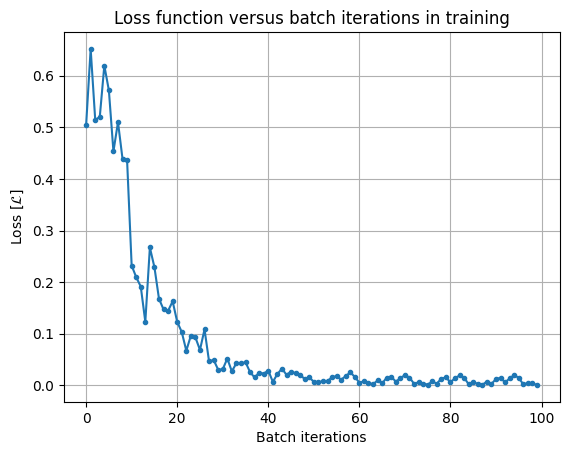

In [19]:
plt.plot(results_dict["loss_history"], ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

## Tuning the threshold $\zeta$

When we have access to labelled anomalous series (as we do in our toy problem here, often not the case in reality), we can tune the threshold $\zeta$ to maximize some success metric. We choose to maximize the accuracy score as defined using the below three electrons.

In [ ]:
@ct.electron
def get_accuracy_score(pred, truth):
    return torch.sum(pred == truth)/truth.size()[0]

@ct.electron
def get_preds_given_threshold(zeta, scores):
    return torch.tensor([-1 if score > zeta else 1 for score in scores])

@ct.electron
def get_truth_labels(normal_series_set, anomalous_series_set):
    norm = torch.ones(normal_series_set.size()[0])
    anom = -torch.ones(normal_series_set.size()[0])
    return torch.cat([norm, anom])

Then, knowing the anomaly scores $a_X(y)$ for a validation data set, we can scan through various zetas on a fine 1D grid and calcuate the accuracy score. Our goal is the pick the $\zeta$ with the largest accuracy score.

In [20]:
@ct.electron
def threshold_scan_acc_score(scores, truth_labels, zeta_min, zeta_max, steps):
    accs = torch.empty(steps)
    for i, zeta in enumerate(torch.linspace(zeta_min, zeta_max, steps)):
        preds = get_preds_given_threshold(zeta, scores)
        accs[i] = get_accuracy_score(preds, truth_labels)
    return accs

@ct.electron
def get_anomaly_score(callable_proj, x, T, alpha_star, mu_star, sigma_star,
                      gamma_length, n_samples, get_time_resolved=False):
    score = torch.empty(T.size()[0])
    for i in range(T.size()[0]):
        score[i] =\
         (1 - F(callable_proj, x[i].unsqueeze(0), T[i].unsqueeze(0),
          alpha_star, mu_star, sigma_star, gamma_length, n_samples)).square()
    if get_time_resolved:
        return score, score.mean()
    else:
        return score.mean()

@ct.electron 
def get_norm_and_anom_scores(X_norm, X_anom, T, callable_proj, model_params,
                             gamma_length, n_samples):
    alpha = model_params['alpha']
    mu = model_params['mu']
    sigma = model_params['sigma']
    norm_scores =\
         torch.tensor(
            [get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma,
                               gamma_length, n_samples) for xt in X_norm]
         )
    anom_scores =\
         torch.tensor(
            [get_anomaly_score(callable_proj, xt, T, alpha, mu, sigma,
                               gamma_length, n_samples) for xt in X_anom]
         )
    return torch.cat([norm_scores, anom_scores])

We now create our second `@ct.lattice`. We are to test the optimal model against two random models. If our model is trainable, we should see that the trained model is better.

In [21]:
@ct.lattice
def threshold_tuning_workflow(opt_params, gamma_length, n_samples, probs_func,
                              zeta_min, zeta_max, steps, p, num_series,
                              noise_amp, spike_amp, max_duration, t_init,
                              t_end, k, U, W, D, n_qubits, random_model_seeds,
                              W_layers):
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp,
                                                    t_init, t_end)
    X_val_anom, T =\
         generate_anomalous_time_series_set(p, num_series, noise_amp,
                                            spike_amp, max_duration,
                                            t_init, t_end)
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits,
                                                probs_func)
    
    accs_list = []; scores_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(X_val_norm, X_val_anom, T, callable_proj,
                                      opt_params, gamma_length, n_samples)
    accs_opt = threshold_scan_acc_score(scores, truth_labels, zeta_min,
                                        zeta_max, steps)
    accs_list.append(accs_opt); scores_list.append(scores)

    # Evaluate random models
    for seed in random_model_seeds:
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(X_val_norm, X_val_anom, T,
                                          callable_proj, rand_params,
                                          gamma_length, n_samples)
        accs_list.append(threshold_scan_acc_score(scores, truth_labels,
                                                  zeta_min, zeta_max, steps))
        scores_list.append(scores)
    return accs_list, scores_list
    

and set the input parameters.

In [22]:
threshold_tuning_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "zeta_min": 0,
    "zeta_max": 1,
    "steps": 100000,
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"]
}

threshold_tuning_options.update(general_options)

As before, we dispatch the lattice to the `Covalent` server.

In [33]:
val_dispatch_id = ct.dispatch(threshold_tuning_workflow)(**threshold_tuning_options)
ct_val_results = ct.get_result(dispatch_id=val_dispatch_id, wait=True)
accs_list, scores_list = ct_val_results.result

Parsing the result, we can see that the optimal model achieves high accuracy. The random models return nearly random results.

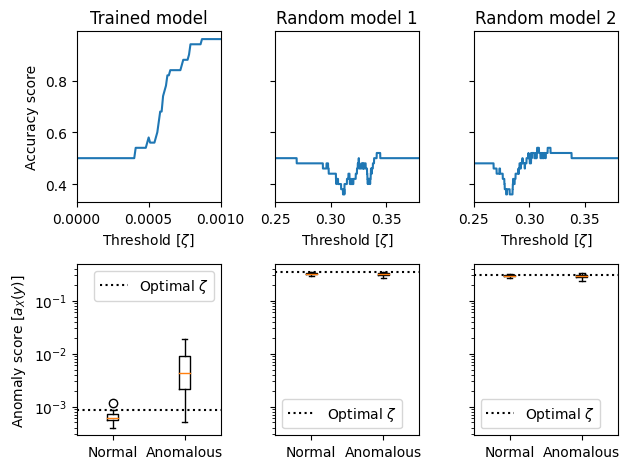

In [35]:
zeta_xlims = [(0, 0.001), (0.25, 0.38), (0.25, 0.38)]
titles = ["Trained model", "Random model 1", "Random model 2"]
zetas = torch.linspace(threshold_tuning_options["zeta_min"],
                       threshold_tuning_options["zeta_max"],
                       threshold_tuning_options["steps"])
fig, axs = plt.subplots(ncols=3, nrows=2, sharey="row")
for i in range(3):
    axs[0, i].plot(zetas, accs_list[i])
    axs[0, i].set_xlim(zeta_xlims[i])
    axs[0, i].set_xlabel("Threshold [$\zeta$]")
    axs[0, i].set_title(titles[i])
    axs[1, i].boxplot([scores_list[i][0:general_options["num_series"]],
                       scores_list[i][general_options["num_series"]:-1]],
                       labels=["Normal", "Anomalous"])
    axs[1, i].set_yscale('log')
    axs[1, i].axhline(zetas[torch.argmax(accs_list[i])], color="k",
                      linestyle=":", label="Optimal $\zeta$")
    axs[1, i].legend()
axs[0, 0].set_ylabel("Accuracy score")
axs[1, 0].set_ylabel("Anomaly score [$a_X(y)$]")
fig.tight_layout()


## Testing the model

Now with an optimal threshold, we can perform testing on the testing data sets. We already have all of the electrons to do this, so we create the `@ct.lattice`

In [24]:
@ct.lattice
def testing_workflow(opt_params, gamma_length, n_samples, probs_func, best_zetas,
                    p, num_series, noise_amp, spike_amp, max_duration, t_init,
                    t_end, k, U, W, D, n_qubits, random_model_seeds, W_layers):
    X_val_norm, T = generate_normal_time_series_set(p, num_series, noise_amp,
                                                    t_init, t_end)
    X_val_anom, T = generate_anomalous_time_series_set(p, num_series, noise_amp,
                                                       spike_amp, max_duration,
                                                       t_init, t_end)
    truth_labels = get_truth_labels(X_val_norm, X_val_anom)
    callable_proj = get_callable_projector_func(k, U, W, D, n_qubits,
                                                probs_func)
    
    accs_list = []
    # Evaluate optimal model
    scores = get_norm_and_anom_scores(X_val_norm, X_val_anom, T, callable_proj,
                                      opt_params, gamma_length, n_samples)
    preds = get_preds_given_threshold(best_zetas[0], scores)
    accs_list.append(get_accuracy_score(preds, truth_labels))
    # Evaluate random models
    for zeta, seed in zip(best_zetas[1:], random_model_seeds):
        rand_params = get_initial_parameters(W, W_layers, n_qubits, seed)
        scores = get_norm_and_anom_scores(X_val_norm, X_val_anom, T,
                                          callable_proj, rand_params,
                                          gamma_length, n_samples)
        preds = get_preds_given_threshold(best_zetas[0], scores)
        accs_list.append(get_accuracy_score(preds, truth_labels))
    return accs_list

and dispatch it to the covalent server with the appropriate parameters.

In [36]:
testing_options = {
    "spike_amp": 0.4,
    "max_duration": 5,
    "best_zetas": [zetas[torch.argmax(accs)] for accs in accs_list],
    "random_model_seeds": [0, 1],
    "W_layers": 2,
    "opt_params": results_dict["opt_params"]
}
                            
testing_options.update(general_options)

test_dispatch_id = ct.dispatch(testing_workflow)(**testing_options)
ct_test_results = ct.get_result(dispatch_id=test_dispatch_id, wait=True)
accs_list = ct_test_results.result

As can be seen, once more, the trained model is far more accurate than the random models.

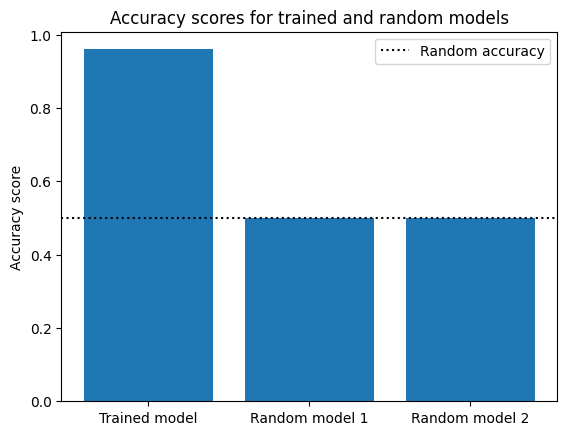

In [37]:
plt.bar([1, 2, 3], accs_list)
plt.axhline(0.5, color="k", linestyle=":", label="Random accuracy")
plt.xticks([1, 2, 3], ["Trained model", "Random model 1", "Random model 2"])
plt.ylabel("Accuracy score")
plt.title("Accuracy scores for trained and random models")
plt.legend()

## References
(1) Baker, Jack S. et al. "Quantum Variational Rewinding for Time Series Anomaly Detection." arXiv preprint [arXiv:2210.164388](https://arxiv.org/abs/2210.16438) (2022). <a name="Baker2022"></a>

(2) Stone, Marshall H. "On one-parameter unitary groups in Hilbert space." Annals of Mathematics, 643-648, [doi:10.2307/1968538](https://doi.org/10.2307/1968538) (1932). <a name="Stone1932"></a>

(3) Welch, Jonathan et al. "Efficient quantum circuits for diagonal unitaries without ancillas", New Journal of Physics, **16**, 033040 [doi:10.1088/1367-2630/16/3/033040](https://doi.org/10.1088/1367-2630/16/3/033040) (2014). <a name="Welch2014"></a>

(4) Cîrstoiu, Cristina et al. "Variational fast forwarding for quantum simulation beyond the coherence time", npj Quantum Information, **6**, [doi:10.1038/s41534-020-00302-0](https://doi.org/10.1038/s41534-020-00302-0), (2020) <a name="Cîrstoiu2020"></a>